# Importing Libraries

In [1]:
import split_data
from dataload.dataload import load_data
from utils.utils import load_checkpoint, build_model, visualize_data
from model.resnet50 import create_model
import torch
from train import train
import torchsummary
%load_ext autoreload
%autoreload 2

# Training

In [2]:
images_dir = '../../data/UTKFace/images'
base_data_dir = '../../data/UTKFace'
train_split = 0.7
valid_split = 0.2

In [3]:
# Hyperparameters
aug_p = 0.4
batch_size = 64
base_model = 'resnet50'
dropout_p = 0.4
freeze = True
num_layers = 120
learning_rate = 1e-03
unfrozen_learning_rate = 3e-05
epochs = 10

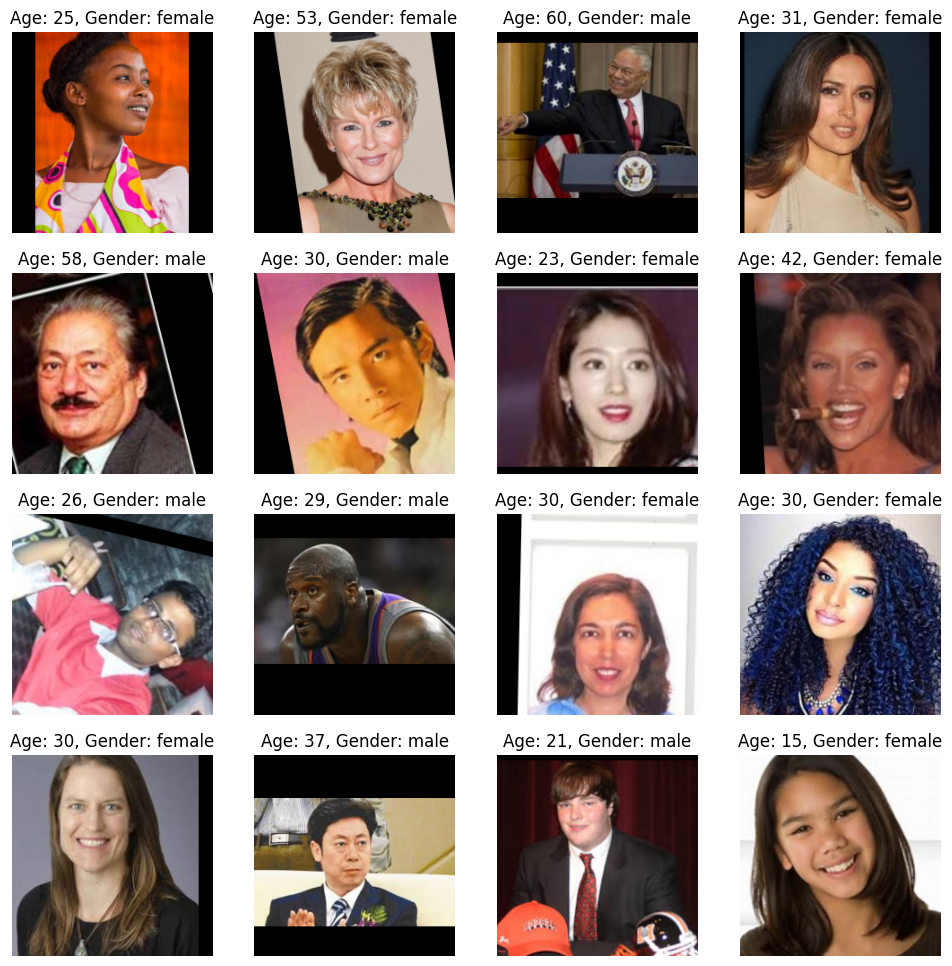

In [8]:
split_data.split(base_data_dir, images_dir, train_split, valid_split)
trainloader, validloader, testloader = load_data(base_data_dir, images_dir, aug_p, batch_size)
visualize_data(trainloader, num_images = 16, figsize=(12, 12))

In [ ]:
model = create_model(base_model, freeze, num_layers, dropout_p)
torchsummary.summary(model)

In [9]:
criterion_mae, criterion_bce, optimizer, scheduler = build_model(model, epochs, learning_rate, True)
model, train_bce_losses, train_mae_losses, valid_bce_losses, valid_mae_losses, \
best_loss = train(trainloader, validloader, model, criterion_mae, criterion_bce, optimizer, epochs, scheduler = scheduler)

 61%|██████    | 160/264 [00:38<00:13,  7.75it/s, bce_loss=0.393, mae_loss=0.155]

In [ ]:
print(f'{"*"*10} Unfreezing {"*"*10}')
# Unfreeze
model = create_model(base_model, freeze = False, dropout_p=dropout_p)
model, _ = load_checkpoint(model, file_path='saved_models/multi_task.pt')
criterion_mae, criterion_bce, optimizer, scheduler = build_model(model, epochs, unfrozen_learning_rate, True)
model, train_bce_losses, train_mae_losses, valid_bce_losses, valid_mae_losses, \
best_loss = train(trainloader, validloader, model, criterion_mae, criterion_bce, optimizer, epochs, best_loss, scheduler)

model_scripted = torch.jit.script(model)
model_scripted.save('saved_models/multitask_final.pt')